In [2]:
import numpy as np
data = np.load("resources/./music_2.npy")
len(data)

100000

In [3]:
data[0]

['track_3248376',
 'artist_4660',
 'track_68116150',
 'artist_210',
 'track_68116150',
 'artist_210',
 'track_3169189',
 'artist_7188',
 'track_6523608',
 'artist_2961',
 'track_407020492',
 'artist_2961',
 'track_6523613',
 'artist_2961',
 'track_348627211',
 'artist_396485',
 'track_348627221',
 'artist_396485',
 'track_348627231',
 'artist_396485',
 'track_348627241',
 'artist_396485',
 'track_348627251',
 'artist_2961',
 'track_348627261',
 'artist_2961',
 'track_348627271',
 'artist_2961',
 'track_348627281',
 'artist_2961',
 'track_348627291',
 'artist_2961']

In [4]:
# récupération uniquement des identifiant de morceaux // suppression des identifiant d'artiste
playlist_track = [list(filter(lambda w: w.split("_")[0]==u"track",playlist)) for playlist in data]

In [5]:
# nombre de morceaux != ?
tracks = np.unique(np.concatenate(playlist_track))
Vt = len(tracks)
Vt

338509

In [6]:
playlist_track[0]

['track_3248376',
 'track_68116150',
 'track_68116150',
 'track_3169189',
 'track_6523608',
 'track_407020492',
 'track_6523613',
 'track_348627211',
 'track_348627221',
 'track_348627231',
 'track_348627241',
 'track_348627251',
 'track_348627261',
 'track_348627271',
 'track_348627281',
 'track_348627291']

In [7]:
track_counts = dict((track,0) for track in tracks)
for p in playlist_track:
    for a in p:
        track_counts[a]=track_counts[a]+1;

In [8]:
# filtrage des morceaux très peu fréquents
playlist_track_filter = [list(filter(lambda a : track_counts[a]> 7, playlist)) for playlist in playlist_track]
track_f = np.unique(np.concatenate(playlist_track_filter))
Vt = len(track_f)
Vt

22733

In [9]:
track_f[0]

'track_100001884'

In [10]:
# construction d'un dict id_morceaux id [0,Vt]
track_dict = dict((track_f[i], i) for i in range(0, Vt))
# conversion des playlisat en liste d'entier
corpus_num_track = [[track_dict[track] for track in play ] for play in playlist_track_filter]

In [11]:
track_dict['track_100001884']

0

In [12]:
corpus_num_track[0]

[10091, 18411, 18411, 10073, 17882]

In [13]:
playlist_track_filter[0]

['track_3248376',
 'track_68116150',
 'track_68116150',
 'track_3169189',
 'track_6523608']

In [14]:
from keras.models import Sequential, Model
from keras.layers import Embedding, Reshape, Activation, Input, Dense
from keras.layers.merge import Dot
from keras.utils import np_utils
from keras.preprocessing.sequence import skipgrams

In [15]:
# hyper-paramètres de word2vec :
# dimension de l'espace latent
vector_dim = 50
# taille de la fenêtre de voisinage
window_width = 5
# sur-échantillonage des exemples négatifs
neg_sample = 4.
# taille des mini-batch
min_batch_size = 50
# coeff pour la loi de tirage des exemple negatif
samp_coef = -0.1

In [16]:
# comptage du nombre d'occurences des morceaux dans les playlist filtrées
tracks_counts_f = dict((track_f[i],0) for i in range(0, Vt))
for p in playlist_track_filter:
    for t in p:
        tracks_counts_f[t]=tracks_counts_f[t]+1;
# construction de la table de tirage des morceaux pour les exmeple negatif en utilisant ces fréquences
spt_tracks=np.array(list(map(lambda a:tracks_counts_f[a],track_f)),np.float)
sptn_tracks=np.power(spt_tracks,samp_coef)
sptn_tracks=sptn_tracks/np.sum(sptn_tracks)
sptn_tracks=np.cumsum(np.sort(sptn_tracks)[::-1])

In [17]:
# construction du réseau word2vec

# entrée deux entier (couple de morceaux)
input_target_t = Input((1,), dtype='int32')
input_context_t = Input((1,), dtype='int32')

# définition de l'embeding
embedding_t_t = Embedding(Vt, vector_dim, input_length=1, name='embedding_t')
# projection du premier morceau
target_t = embedding_t_t(input_target_t)
target_t = Reshape((vector_dim, 1))(target_t)

# projection du second morceaux
context_t = embedding_t_t(input_context_t)
context_t = Reshape((vector_dim, 1))(context_t)

# calcul de la sortie
dot_product_t = Dot(axes=0)([target_t, context_t])
dot_product_t = Reshape((1,))(dot_product_t)
output_t = Dense(1, activation='sigmoid',name="classif")(dot_product_t)

# definition du modèle
SkipGram_t = Model(inputs=[input_target_t, input_context_t], outputs=output_t)
SkipGram_t.compile(loss='binary_crossentropy', optimizer='adam')


In [18]:
# définition du générateur de couple de morceaux (y=0 <-> aléatoire, y=1 <-> proche dans une playlist)
import random
def track_ns_generator(corpus_num,nbm):
    while 1:
        Data=[]
        Labels=[]
        for i, doc in enumerate(random.sample(corpus_num,nbm)):
            data, labels = skipgrams(sequence=doc, vocabulary_size=Vt, window_size=window_width, negative_samples=neg_sample,sampling_table=sptn_tracks)
            if (len(data)>0):
                Data.append(np.array(data, dtype=np.int32))
                Labels.append(np.array(labels, dtype=np.int32))
        Data=np.concatenate(Data)
        Labels=np.concatenate(Labels)
        x=[Data[:,0],Data[:,1]]
        y=Labels
        yield (x,y)

In [19]:
# ensemble de test et d'apprentissage
index_tst = np.random.choice(100000,10000)
index_app  = np.setdiff1d(range(100000),index_tst)

play_app   = [corpus_num_track[i] for i in index_app]
play_tst  = [corpus_num_track[i] for i in index_tst]

In [20]:
hist=SkipGram_t.fit_generator(track_ns_generator(play_app,min_batch_size),200,50)

Epoch 1/50
200/200 [==============================] - 12s 58ms/step - loss: 0.6648
Epoch 2/50
200/200 [==============================] - 11s 57ms/step - loss: 0.6085
Epoch 3/50
200/200 [==============================] - 11s 54ms/step - loss: 0.5437
Epoch 4/50
200/200 [==============================] - 11s 55ms/step - loss: 0.5006
Epoch 5/50
200/200 [==============================] - 11s 56ms/step - loss: 0.4712
Epoch 6/50
200/200 [==============================] - 11s 56ms/step - loss: 0.4461
Epoch 7/50
200/200 [==============================] - 11s 56ms/step - loss: 0.4287
Epoch 8/50
200/200 [==============================] - 11s 56ms/step - loss: 0.4096
Epoch 9/50
200/200 [==============================] - 11s 55ms/step - loss: 0.3941
Epoch 10/50
200/200 [==============================] - 11s 56ms/step - loss: 0.3762
Epoch 11/50
200/200 [==============================] - 11s 53ms/step - loss: 0.3639
Epoch 12/50
200/200 [==============================] - 11s 54ms/step - loss: 0.3505
E

In [21]:
# récupérations des positions des morceaux dans l'espace de projection
vectors_tracks = SkipGram_t.get_weights()[0]

In [22]:
from sklearn.metrics import pairwise_distances

In [23]:
# fonction retpournant les indices des s plus proches voisins des seeds dans la matrice X
# a vous de jouer avec pairwise_distances, np.min, np.argsort,...
def predict(seeds,s,X, metrics="cosine"):
    V = X.shape[0]
    D = pairwise_distances(X[seeds,:],X[np.setdiff1d(range(V),seeds),:],metrics)
    return np.argsort(np.min(D,0))[:s]

In [24]:
# exemple pour 4 suggestions avec les 2 premiers morceaux en seeds 
pr=predict([0,1],4,vectors_tracks)
pr

array([   13,   886, 10129,     0], dtype=int64)

In [25]:
np.setdiff1d(range(10), [0,1,48, 9, 4])

array([2, 3, 5, 6, 7, 8])

In [26]:
pairwise_distances([[1,2,3],[1,2,4]], metric='cosine')

array([[0.        , 0.00853987],
       [0.00853987, 0.        ]])

In [ ]:
# estimation des performances
# hit@10
# nombre de bonne prediction
goodpred = []
# nombre de predictions faites
nbpred   = []
# pour chaque playlist
for p in play_tst:
    # si au moins deux chansons
    if (len(p)>1):
        # recuperations des seeds 5 premiers morceaux ou moins si la playlist contient moins de 5 morceaux
        seeds  = p[:np.min([5,len(p)-1])]
        # recuperations de la suite de la playlist que nous allons comparer à nos suggestions
        topred = p[np.min([5,len(p)-1]):]
        # construction des suggestions 10 suggestions par morceaux a predire
        prediction = predict(seeds,10*len(topred),vectors_tracks)
        # comptage du nombre de morceaux présent dans nos suggestions
        goodpred.append(len(np.intersect1d(prediction,topred)))
        # stockage du nombre de predictions
        nbpred.append(len(topred))
# proportions de morceux présents dans nos suggestions
hitat10 = np.sum(goodpred)/np.sum(nbpred)


In [27]:
def test_pairwise(metrics='euclidean'):
    # nombre de bonne prediction
    goodpred = []
    # nombre de predictions faites
    nbpred   = []
    # pour chaque playlist
    for p in play_tst:
        # si au moins deux chansons
        if (len(p)>1):
            # recuperations des seeds 5 premiers morceaux ou moins si la playlist contient moins de 5 morceaux
            seeds  = p[:np.min([5,len(p)-1])]
            # recuperations de la suite de la playlist que nous allons comparer à nos suggestions
            topred = p[np.min([5,len(p)-1]):]
            # construction des suggestions 10 suggestions par morceaux a predire
            prediction = predict(seeds,10*len(topred),vectors_tracks, metrics)
            # comptage du nombre de morceaux présent dans nos suggestions
            goodpred.append(len(np.intersect1d(prediction,topred)))
            # stockage du nombre de predictions
            nbpred.append(len(topred))
    # proportions de morceux présents dans nos suggestions
    return np.sum(goodpred)/np.sum(nbpred)

In [ ]:
#Euclidean
hitat10_euclidean = test_pairwise()

#Cosine
hitat10_cosine = test_pairwise('cosine')

#manhattan
hitat10_manhattan = test_pairwise('manhattan')

#blockcity
hitat10_manhattan = test_pairwise('manhattan')

#manhattan
hitat10_manhattan = test_pairwise('manhattan')

#manhattan
hitat10_manhattan = test_pairwise('manhattan')

In [33]:
_VALID_METRICS = ['euclidean', 'cosine', 'manhattan']
hitat10_results = dict((metric, test_pairwise(metric)) for metric in _VALID_METRICS)

In [34]:
hitat10_results

{'euclidean': 0.10963523566813396,
 'cosine': 0.12744870903802094,
 'manhattan': 0.10708677632764435}

In [35]:
import operator
sorted_hitat10 = sorted(hitat10_results.items(), key=operator.itemgetter(1))
sorted_hitat10

[('manhattan', 0.10708677632764435),
 ('euclidean', 0.10963523566813396),
 ('cosine', 0.12744870903802094)]

In [36]:
import matplotlib.pyplot as plt


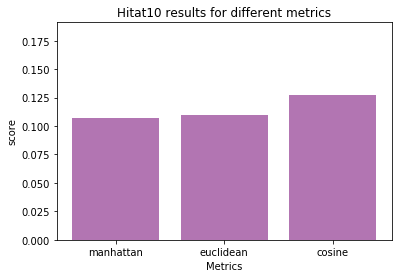

In [37]:
fig, ax = plt.subplots()

# Dataset
values = []
labels = []
for item in sorted_hitat10:
    values.append(item[1])
    labels.append(item[0])

# Create bars and choose color
y_pos = np.arange(len(labels))
plt.bar(y_pos, values, color = (0.5,0.1,0.5,0.6))

# Add title and axis names
plt.title('Hitat10 results for different metrics')
plt.xlabel('Metrics')
plt.ylabel('score')
 
# Limits for the Y axis
plt.ylim(0, np.max(values) * 1.5)
 
# Create names
plt.xticks(y_pos, labels)
 
# Show graphic
plt.show()


In [38]:
from sklearn.neighbors import NearestNeighbors
samples = [[0,0,2], [1,0,0], [0,0,1]]

In [39]:
neigh = NearestNeighbors(2)
neigh.fit(samples)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=2, p=2, radius=1.0)

In [40]:
l = [[0,0,1.3],[1,1,1]]
nbrs = neigh.kneighbors(l, 2, return_distance=False)
np.asarray(nbrs[0][0])

array(2, dtype=int64)

In [41]:
nbrs

array([[2, 0],
       [1, 2]], dtype=int64)

In [176]:
neigh = NearestNeighbors(5, algorithm='auto', metric='yule')
neigh.fit(vectors_tracks)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='yule',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [177]:
play_0 = play_tst[0]
nbrs = neigh.kneighbors(vectors_tracks[play_0, :], 20, return_distance=False)
#prediction = predict(seeds,10*len(topred),vectors_tracks)

C:\Users\Maxime\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype float32 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Maxime\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype float32 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


In [178]:
nbrs[0]

array([15152, 15148, 15146, 15163, 15144, 15143, 15147, 15145, 15162,
       15153, 15154, 15155, 15156, 15157, 15158, 15159, 15160, 15151,
       15150, 15149], dtype=int64)

In [148]:
ll = [[1,2,3],[4,5,6],[9,8,5,5]]
list(map(lambda x : x[1:], ll))

[[2, 3], [5, 6], [8, 5, 5]]

In [149]:
def predict(seeds,s,X, metrics="cosine"):
    V = X.shape[0]
    D = pairwise_distances(X[seeds,:],X[np.setdiff1d(range(V),seeds),:],metrics)
    return np.argsort(np.min(D,0))[:s]


def test_kneighbors():
    # nombre de bonne prediction
    goodpred = []
    # nombre de predictions faites
    nbpred   = []
    # pour chaque playlist
    for p in play_tst:
        # si au moins deux chansons
        if (len(p)>1):
            # recuperations des seeds 5 premiers morceaux ou moins si la playlist contient moins de 5 morceaux
            seeds  = p[:np.min([5,len(p)-1])]
            # recuperations de la suite de la playlist que nous allons comparer à nos suggestions
            topred = p[np.min([5,len(p)-1]):]
            # construction des suggestions 10 suggestions par morceaux a predire
            prediction = neigh.kneighbors(vectors_tracks[seeds, :], 10*len(topred), return_distance=False)
            
            # filter first prediction since it is the track itself (distance is 0) UTIL ??
 
            #prediction = predict(seeds,10*len(topred),vectors_tracks, metrics)
            # comptage du nombre de morceaux présent dans nos suggestions
            goodpred.append(len(np.intersect1d(prediction,topred)))
            # stockage du nombre de predictions
            nbpred.append(len(topred))
    # proportions de morceux présents dans nos suggestions
    return np.sum(goodpred)/np.sum(nbpred)

In [89]:
#braycurtis
test_kneighbors()

0.45627719000180195

In [55]:
#minkowski
test_kneighbors()

0.40021108451103043

In [93]:
#canberra
test_kneighbors()

0.42361057481916237

In [104]:
#chebyshev
test_kneighbors()

0.34736273071279633

In [110]:
#correlation
test_kneighbors()

0.4556593816768348

In [116]:
#dice
test_kneighbors()

0.007671120035009139

In [129]:
#hamming
test_kneighbors()

0.06716091332664041

In [135]:
#jaccard
test_kneighbors()

0.007671120035009139

In [150]:
#kulsinski
test_kneighbors()

0.007671120035009139

In [151]:
#mahalanobis
neigh = NearestNeighbors(5, algorithm='auto', metric='mahalanobis')
neigh.fit(vectors_tracks)
test_kneighbors()

ValueError: Must provide either V or VI for Mahalanobis distance

In [152]:
#rogerstanimoto
neigh = NearestNeighbors(5, algorithm='auto', metric='rogerstanimoto')
neigh.fit(vectors_tracks)
test_kneighbors()

0.007671120035009139

In [153]:
#russellrao
neigh = NearestNeighbors(5, algorithm='auto', metric='russellrao')
neigh.fit(vectors_tracks)
test_kneighbors()

0.007671120035009139

In [ ]:
#seuclidean
neigh = NearestNeighbors(5, algorithm='auto', metric='seuclidean')
neigh.fit(vectors_tracks)
test_kneighbors()

In [180]:
#sokalmichener
neigh = NearestNeighbors(5, algorithm='auto', metric='sokalmichener')
neigh.fit(vectors_tracks)
test_kneighbors()

0.007671120035009139

In [181]:
#sokalsneath
neigh = NearestNeighbors(5, algorithm='auto', metric='sokalsneath')
neigh.fit(vectors_tracks)
test_kneighbors()

0.007671120035009139

In [182]:
#sqeuclidean
neigh = NearestNeighbors(5, algorithm='auto', metric='sqeuclidean')
neigh.fit(vectors_tracks)
test_kneighbors()

0.40021108451103043

In [179]:
#yule
neigh = NearestNeighbors(5, algorithm='auto', metric='yule')
neigh.fit(vectors_tracks)
test_kneighbors()

C:\Users\Maxime\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype float32 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Maxime\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype float32 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Maxime\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype float32 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Maxime\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype float32 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Maxime\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with in

0.007722604062089736